# Introduction

Over the next few days, this notebook will house PC's figure-generation for the multiplex effects section of Friday's presentation. Long term, this is the code to generate figures for the paper. 

In [2]:
import matplotlib
matplotlib.use('Agg')

# Get setup

#plots in the doc
% matplotlib inline 

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import pandas as pd
import fiona
# preferences across the worksheet
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# read in necessary data
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

In [4]:
# Scale congested_time_m in metro layer so that mean metro speed equals mean street speed. 

dists = nx.get_edge_attributes(multi.G, 'dist_km')
times = nx.get_edge_attributes(multi.G, 'congested_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}

nx.set_edge_attributes(multi.G, 'speed_km_m', speed_km_m)

street_speed = multi.mean_edge_attr_per(layers = ['streets'], attr = 'speed_km_m', weight_attr = 'dist_km')
metro_speed = multi.mean_edge_attr_per(layers = ['metro'], attr = 'speed_km_m', weight_attr = 'dist_km') 

scale = street_speed / metro_speed
print scale

multi.scale_edge_attribute(layer = 'metro', attribute = 'congested_time_m', beta = 1/scale)

0.981006862644


In [5]:
# set betas
betas = [10.0, 1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01]

# for plotting, we'll need this many colors
sns.set_palette(sns.cubehelix_palette(n_colors = len(betas)))

n_nodes = None

In [6]:
# Re-pull g and get a fresh copy of the OD table (just in case)
g = utility.nx_2_igraph(multi.as_graph())
nodes = np.array([v.index for v in g.vs if g.vs[v.index]['layer'] == 'taz']) # nodes to compute demand from/to

if n_nodes: # optional node sampling
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False) # need to re-key since we are working with a different graph now

# Shortest path lengths

In [7]:
od_lengths = od

In [8]:
od_lengths

,o,d,flow_norm
0,6,6,2.776667
1,6,3383,2.776667
2,6,3384,2.776667
3,3383,6,2.776667
4,3383,3383,2.776667
5,3383,3384,2.776667
6,3384,6,2.776667
7,3384,3383,2.776667
8,3384,3384,2.776667
9,6,14,2.173333


In [9]:
for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = beta)
    p = analysis.path_lengths_igraph(g, nodes, 'congested_time_m', mode = 'list')
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]
    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, beta : p})
    od_lengths = od_lengths.merge(lengths)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = 1.0 / beta)

In [10]:
od_lengths.head()

,o,d,flow_norm,10.0,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.01
0,6,6,2.776667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,6,3383,2.776667,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239,7.205239
2,6,3384,2.776667,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808,5.987808
3,3383,6,2.776667,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244,4.225244
4,3383,3383,2.776667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Betweenness

In [11]:
G = multi.layers_as_subgraph(['taz', 'streets', 'metro'])
g = utility.nx_2_igraph(G)
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt')

In [12]:
# ids = np.array([g.vs[i]['id'] for i in range(len(g.vs))])

ids = g.vs.select(lambda v : v['layer'] == 'streets')

ids = np.array([ids[i]['id'] for i in range(len(ids))])
ids
df = pd.DataFrame({'ids' : ids})

In [13]:
for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = beta)
    analysis.weighted_betweenness(g, od, weight = 'congested_time_m', scale = .25, attrname = 'congested_betweenness')
    d = {g.vs[i]['id'] : g.vs[i]['congested_betweenness'] for i in range(len( g.vs))}
    df[beta] = df['ids'].map(d.get)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = 1.0 / beta)

In [14]:
od_betweenness = df[df.ids.str.contains('streets')]

# Flow and time lost to congestion

In [15]:
from collections import defaultdict

edge_dict = defaultdict(int)

for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = beta)
    es = g.es
    es['flow_' + str(beta)] = 0
    
    for o in od:
        ds = od[o]
        if len(ds) > 0:
            targets = ds.keys()
            paths = g.get_shortest_paths(o,
                                         to=targets,
                                         weights='congested_time_m',
                                         mode='OUT',
                                         output='epath')
            for i in range(len(targets)):
                flow = od[o][targets[i]]
                for e in paths[i]:
                    edge_dict[e] += flow
                    
            for key in edge_dict:
                es[key]['flow_' + str(beta)] = edge_dict[key]

    f = {(g.vs[g.es[i].source]['id'], g.vs[g.es[i].target]['id']) : g.es[i]['flow_' + str(beta)] for i in range(len(g.es))}
    nx.set_edge_attributes(multi.G, 'flow_' + str(beta), 0)
    nx.set_edge_attributes(multi.G, 'flow_' + str(beta), f)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = 1.0 / beta)

In [16]:
flows = ['flow_' + str(beta) for beta in betas]

cols = ['layer', 'free_flow_time_m', 'capacity', 'dist_km']  + flows

j = utility.edges_2_df(multi.G, attrs = cols)

In [17]:
j

,capacity,dist_km,flow_0.01,flow_0.1,flow_0.2,flow_0.3,flow_0.4,flow_0.5,flow_0.6,flow_0.7,flow_0.8,flow_0.9,flow_1.0,flow_10.0,free_flow_time_m,layer
0,10000000000,0.000015,8898.053333,8156.548889,7415.044444,6673.540000,5932.035556,5190.531111,4449.026667,3707.522222,2966.017778,2224.513333,1483.008889,741.504444,1.480161e-15,taz--streets
1,10000000000,0.000036,8898.053333,8156.548889,7415.044444,6673.540000,5932.035556,5190.531111,4449.026667,3707.522222,2966.017778,2224.513333,1483.008889,741.504444,3.618400e-15,taz--streets
2,10000000000,0.000045,13389.600000,12273.800000,11158.000000,10042.200000,8926.400000,7810.600000,6694.800000,5579.000000,4463.200000,3347.400000,2231.600000,1115.800000,4.468062e-15,taz--streets
3,10000000000,0.000008,13389.600000,12273.800000,11158.000000,10042.200000,8926.400000,7810.600000,6694.800000,5579.000000,4463.200000,3347.400000,2231.600000,1115.800000,7.533314e-16,taz--streets
4,10000000000,0.000021,20615.013333,18897.095556,17179.177778,15461.260000,13743.342222,12025.424444,10307.506667,8589.588889,6871.671111,5153.753333,3435.835556,1717.917778,2.064210e-15,taz--streets
5,10000000000,0.000021,20615.013333,18897.095556,17179.177778,15461.260000,13743.342222,12025.424444,10307.506667,8589.588889,6871.671111,5153.753333,3435.835556,1717.917778,2.128551e-15,taz--streets
6,10000000000,0.000050,20615.013333,18897.095556,17179.177778,15461.260000,13743.342222,12025.424444,10307.506667,8589.588889,6871.671111,5153.753333,3435.835556,1717.917778,5.037228e-15,taz--streets
7,10000000000,0.000050,16559.320000,15179.376667,13799.433333,12419.490000,11039.546667,9659.603333,8279.660000,6899.716667,5519.773333,4139.830000,2759.886667,1379.943333,4.990035e-15,taz--streets
8,10000000000,0.000054,16559.320000,15179.376667,13799.433333,12419.490000,11039.546667,9659.603333,8279.660000,6899.716667,5519.773333,4139.830000,2759.886667,1379.943333,5.359174e-15,taz--streets
9,2850,1.377571,5943.405000,5448.121250,4952.837500,4457.553750,3962.270000,3466.986250,2971.702500,2476.418750,1981.135000,1485.851250,990.567500,495.283750,4.026062e+00,streets


In [18]:
for beta in betas:
    j['time_lost_' + str(beta)] = j['flow_' + str(beta)] * j['free_flow_time_m'] *.15 * (j['flow_' + str(beta)] / j['capacity']) ** 4

In [19]:
time_lost = j.groupby('layer')[['time_lost_' + str(beta) for beta in betas]].sum()

In [29]:
time_lost

,time_lost_10.0,time_lost_1.0,time_lost_0.9,time_lost_0.8,time_lost_0.7,time_lost_0.6,time_lost_0.5,time_lost_0.4,time_lost_0.3,time_lost_0.2,time_lost_0.1,time_lost_0.01
layer,,,,,,,,,,,,
metro,NaN,5.414097e-68,3.189916e-66,4.209710e-65,2.740783e-64,1.273188e-63,4.770649e-63,1.481065e-62,3.981195e-62,9.523947e-62,2.090050e-61,4.264691e-61
metro--streets,NaN,2.005227e-28,1.111136e-26,1.597319e-25,1.194864e-24,6.402074e-24,2.985835e-23,1.161878e-22,3.971497e-22,1.162927e-21,3.102599e-21,7.535270e-21
streets,3.670313e+10,3.582041e+11,1.705062e+12,4.817299e+12,1.069971e+13,2.150731e+13,4.099980e+13,7.757322e+13,1.400432e+14,2.485740e+14,4.272725e+14,7.185271e+14
taz--streets,1.510714e-34,4.834284e-33,3.671034e-32,1.546971e-31,4.720980e-31,1.174731e-30,2.539057e-30,4.950307e-30,8.920613e-30,1.510714e-29,2.433020e-29,3.759139e-29


In [20]:
time_lost_dict = {beta : time_lost['time_lost_' + str(beta)]['streets'] for beta in betas}

In [21]:
flow_dict = {}
for beta in betas:
    j['total_flow'] = j['flow_' + str(beta)] * j['dist_km']
    flows = j.groupby('layer').sum()['total_flow']
    flows['metro'] / (flows['streets'] + flows['metro'])
    flow_dict[beta] = np.nan_to_num(flows['metro'] / (flows['streets'] + flows['metro']))


# Visualization

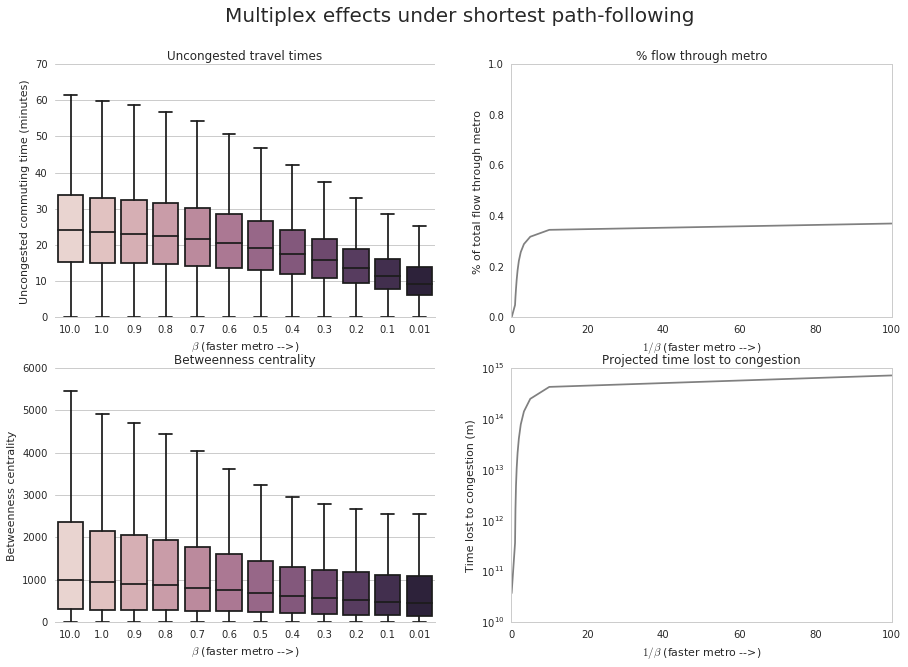

In [43]:
# Could use tightening but is basically good. 

pylab.rcParams['savefig.dpi'] = 72

sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
sns.boxplot(od_lengths[betas], fliersize = 0, ax = ax1)

ax1.set(title = r'Uncongested travel times',
      xlabel = r'$\beta$ (faster metro -->)',
      ylabel = 'Uncongested commuting time (minutes)',
      ylim = (0,70))

sns.despine(top = True, left = True)



x = sorted([beta for beta in flow_dict.keys()])
y = [flow_dict[beta] for beta in x]
x = [1/beta for beta in x]

flow_dict.values()

sns.set_style("whitegrid")
ax3 = fig.add_subplot(223)

sns.boxplot(od_betweenness[betas], fliersize = 0, ax = ax3)

ax3.set(title = r'Betweenness centrality',
      xlabel = r'$\beta$ (faster metro -->)',
      ylabel = 'Betweenness centrality',
      ylim = (0,6000))

sns.despine(top = True, left = True)

#  
sns.set_style("whitegrid", {'axes.grid' : False})

ax2 = fig.add_subplot(222)

ax2.plot(x,y, color = 'grey')
ax2.set(title = '% flow through metro',
       xlabel = r'$1/\beta$ (faster metro -->)',
       ylabel = '% of total flow through metro',
       ylim = (0,1))



# 
ax4 = fig.add_subplot(224)
sns.set_style("whitegrid", {'axes.grid' : False})
x = sorted([beta for beta in time_lost_dict.keys()])
y = [time_lost_dict[beta] for beta in x]
x = [1/beta for beta in x]


ax4.semilogy(x,y, color = 'grey')
ax4.set(title = 'Projected time lost to congestion',
       xlabel = r'$1/\beta$ (faster metro -->)',
       ylabel = 'Time lost to congestion (m)')
# plt.tight_layout()

fig.suptitle('Multiplex effects under shortest path-following', fontsize = 20)
plt.savefig('4_figs/multiplex_shortest.png')